<a href="https://colab.research.google.com/github/badamosor/csci-5922/blob/master/arabic_seq2seq_attn_dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import nltk
nltk.download('punkt')


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        
    def addSentence(self, sentence):
        #print("input:", sentence)
        tokenized_text = nltk.word_tokenize(sentence)

        #print("tokenized:", tokenized_text)
        for word in tokenized_text:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
import codecs
import csv
import random
from sklearn.model_selection import train_test_split

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    

    #FILENAME = "arabic_words.csv"
    FILENAME_TRAIN = "trainig_data_3000.csv"
    FILENAME_TEST = "test_data_3000_425.csv"
    

    ENCODING = 'utf-8'
    train_pairs = []
    with codecs.open(FILENAME_TRAIN, "r", ENCODING) as fp:
      reader = csv.reader(fp)
      for rows in reader:
        train_pairs.append(rows)
        
    test_pairs = []
    with codecs.open(FILENAME_TEST, "r", ENCODING) as fp:
      reader = csv.reader(fp)
      for rows in reader:
        test_pairs.append(rows)
      
        
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    
    
    return input_lang, output_lang, train_pairs, test_pairs


        

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, train_pairs, test_pairs = readLangs(lang1, lang2, reverse)
  
    print("Read %s training sentence pairs" % len(train_pairs))
  
    #pairs = filterPairs(pairs)
    #print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in train_pairs:
        #print("printing pairs:", pair[0], pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    ##!!!Adding new words in test to training words
    
    print("Read %s test sentence pairs" % len(test_pairs))
    print("Counting words...")
    for pair in test_pairs:
        #print("printing pairs:", pair[0], pair[1])
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, train_pairs, test_pairs


input_lang, output_lang, train_pairs, test_pairs = prepareData('NoDiac', 'Diac', False)
print(random.choice(train_pairs))
print(random.choice(test_pairs))



Reading lines...
Read 3002 training sentence pairs
Counting words...
Counted words:
NoDiac 6576
Diac 8264
Read 426 test sentence pairs
Counting words...
Counted words:
NoDiac 6576
Diac 8322
['حمل معدول بحمل أي', 'حِمْل مَعْدُولٍ بحِمْلٍ أَي']
['كسكر قرب واسط وعمر', 'كسُكَّرٍ قُرْبَ واسِطَ وعُمْرُ']


In [7]:
print([input_lang.word2index])
print([output_lang.word2index])


[{'no_diacritics': 2, 'كلمات': 3, 'أو': 4, 'تعابير': 5, 'مطابقة': 6, 'خلاف': 7, 'العجم': 8, 'وهما': 9, 'واحد': 10, 'عبدالمؤمن': 11, 'ابن': 12, 'عبدالقدوس': 13, 'فأما': 14, 'البهط': 15, 'وحيتانكم': 16, 'فما': 17, 'زلت': 18, 'فلم': 19, 'أر': 20, 'فيها': 21, 'كضب': 22, 'كبيض': 23, 'الدجاج': 24, 'وبيض': 25, 'الجراد': 26, 'شفاء': 27, 'القرم': 28, 'ومكن': 29, 'الضباب': 30, 'طعام': 31, 'العريـ': 32, 'ـب': 33, 'لا': 34, 'تشتهيه': 35, 'نفوس': 36, 'صغرهم': 37, 'جذيلها': 38, 'المحكك': 39, 'وعذيقها': 40, 'المرجب': 41, 'والعرب': 42, 'العاربة': 43, 'هم': 44, 'الخلص': 45, 'لائل': 46, 'تقول': 47, 'عرب': 48, 'عاربة': 49, 'وعرباء': 50, 'صرحاء': 51, 'ومتعربة': 52, 'ومستعربة': 53, 'الأعراب': 54, 'آمنا': 55, 'قل': 56, 'لم': 57, 'تؤمنوا': 58, 'ولكن': 59, 'قولوا': 60, 'أسلمنا': 61, 'أشد': 62, 'كفرا': 63, 'ونفاقا': 64, 'العذب': 65, 'من': 66, 'الشراب': 67, 'والطعام': 68, 'وتقي': 69, 'ساكت': 70, 'عنه': 71, 'للتقية': 72, 'عربي': 73, 'وفرس': 74, 'معرب': 75, 'خلصت': 76, 'عربيته': 77, 'وعرب': 78, 'الفرس': 79, 'بزغه

In [0]:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
MAX_LENGTH = 10
loss_per_iter = []
avg_loss_per_iter = []
sent_accur = []
word_accur = []
sent_accur.insert(0,0)
word_accur.insert(0,0)

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
       

In [0]:
def indexesFromSentence(lang, sentence):
      return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    #print("Pair is:",pair[0],pair[1])
    #print("Tensors:",input_tensor, target_tensor)
    return (input_tensor, target_tensor)

In [0]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    #print("input_length",input_length,"target_length:",target_length)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    #print(encoder_outputs.shape)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    
    criterion = nn.NLLLoss()
        
    for i in range(n_iters):
      
      numExample = 0
      for pairs in train_pairs:
          training_pair = tensorsFromPair(pairs)
          input_tensor = training_pair[0]
          target_tensor = training_pair[1]

          loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
          print_loss_total += loss
          plot_loss_total += loss

#        if iter % print_every == 0:
          numExample += 1
          if (numExample % print_every == 0):       
              print_loss_avg = print_loss_total / print_every
              print_loss_total = 0
            #print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         #iter, iter / n_iters * 100, print_loss_avg))
              print('%s %d %.4f %d' % (timeSince(start, numExample), numExample, print_loss_avg, n_iters))
               
      print(('%.4f,%.4f') % ((print_loss_total / print_every),loss))
      
      loss_per_iter.append(loss)
      avg_loss_per_iter.append(print_loss_total / print_every)
    return [loss,print_loss_total / print_every]

Evaluation





In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
           #decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                #if (topi.item() not in output_lang.test_index2word):
                  #decoded_words.append("unk")
                #else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    correct_word_pair = 0
    incorrect_word_pair = 0
    
    correct_sentence_pair = 0
    incorrect_sentence_pair = 0
    
    for pair in test_pairs:
      
        #pair = random.choice(pairs)
        #pair = random.choice(test_pairs)
        #print('>', pair[0])
        #print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        #output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        #print('<', output_sentence)
        #print('')
        
        #Accuracy on sentence basis
        if (pair[1] == output_sentence):
            correct_sentence_pair += 1
        else:
            incorrect_sentence_pair += 1
            
        #Accuracy on word basis
        tokenized_target = nltk.word_tokenize(pair[1])
        
        for target, output in zip(tokenized_target, output_words):
          if (target == output):
            correct_word_pair += 1
          else:
            incorrect_word_pair += 1
            #print("Incorrect word pair:")
            #print(target, output)
                
    print("accuracy of sentences:",correct_sentence_pair/(correct_sentence_pair+incorrect_sentence_pair),correct_sentence_pair,incorrect_sentence_pair) 
    print("accuracy of words:",correct_word_pair/(correct_word_pair+incorrect_word_pair),correct_word_pair,incorrect_sentence_pair)
    sent_accur.append(correct_sentence_pair/(correct_sentence_pair+incorrect_sentence_pair)) 
    word_accur.append(correct_word_pair/(correct_word_pair+incorrect_word_pair))    
    return [correct_sentence_pair/(correct_sentence_pair+incorrect_sentence_pair),correct_word_pair/(correct_word_pair+incorrect_word_pair)]

In [17]:
print("input:", input_lang.n_words)
print("train size", len(train_pairs))

input: 6576
train size 3002


In [0]:
hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)


In [0]:
model_save_name = 'encoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
encoder1.load_state_dict(torch.load(path))
model_save_name = 'decoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
attn_decoder1.load_state_dict(torch.load(path))


In [19]:
trainIters(encoder1, attn_decoder1, 10, print_every=3000)
evaluateRandomly(encoder1, attn_decoder1)

7m 26s (- -8m 33s) 3000 6.4018 10
0.0046,6.6363
15m 11s (- -16m 49s) 3000 6.5972 10
0.0042,6.0072
23m 10s (- -24m 49s) 3000 6.1273 10
0.0039,5.4818
32m 10s (- -33m 49s) 3000 5.5403 10
0.0035,4.6990
40m 52s (- -41m 7s) 3000 4.9142 10
0.0031,4.1177
49m 11s (- -50m 49s) 3000 4.2845 10
0.0026,3.5959
57m 57s (- -58m 3s) 3000 3.6546 10
0.0022,3.0162
66m 31s (- -67m 30s) 3000 3.0441 10
0.0018,2.5983
75m 21s (- -76m 39s) 3000 2.4649 10
0.0014,2.1075
83m 55s (- -84m 6s) 3000 1.9100 10
0.0010,1.3221
accuracy of sentences: 0.002347417840375587 1 425
accuracy of words: 0.16558249556475457 280 425


[0.002347417840375587, 0.16558249556475457]

In [0]:
model_save_name = 'encoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(attn_decoder1.state_dict(), path)

In [21]:
trainIters(encoder1, attn_decoder1, 10, print_every=3000, learning_rate=0.001)

8m 28s (- -9m 31s) 3000 1.8012 10
0.0008,0.9466
16m 59s (- -17m 0s) 3000 1.6746 10
0.0008,1.0345
25m 45s (- -26m 14s) 3000 1.5952 10
0.0008,0.9814
34m 56s (- -35m 3s) 3000 1.5263 10
0.0007,0.9733
43m 33s (- -44m 27s) 3000 1.4636 10
0.0007,0.9312
52m 34s (- -53m 26s) 3000 1.4035 10
0.0007,1.0138
61m 32s (- -62m 28s) 3000 1.3469 10
0.0007,0.9547
70m 46s (- -71m 15s) 3000 1.2940 10
0.0007,0.9296
79m 47s (- -80m 14s) 3000 1.2413 10
0.0006,0.9032
88m 38s (- -89m 23s) 3000 1.1921 10
0.0006,0.8827


[0.8827384948730469, 0.0006125041325887044]

In [0]:
model_save_name = 'encoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(attn_decoder1.state_dict(), path)

In [23]:
evaluateRandomly(encoder1, attn_decoder1)

accuracy of sentences: 0.004694835680751174 2 424
accuracy of words: 0.26730310262529833 448 424


[0.004694835680751174, 0.26730310262529833]

In [24]:
trainIters(encoder1, attn_decoder1, 10, print_every=3000, learning_rate=0.001)

8m 32s (- -9m 27s) 3000 1.1452 10
0.0006,0.8938
17m 31s (- -18m 29s) 3000 1.0986 10
0.0006,0.8328
26m 18s (- -27m 42s) 3000 1.0535 10
0.0006,0.8409
35m 2s (- -36m 58s) 3000 1.0101 10
0.0006,0.8274
43m 38s (- -44m 22s) 3000 0.9701 10
0.0005,0.8016
52m 30s (- -53m 30s) 3000 0.9311 10
0.0005,0.7635
61m 19s (- -62m 41s) 3000 0.8935 10
0.0005,0.7896
70m 13s (- -71m 47s) 3000 0.8575 10
0.0005,0.7171
79m 14s (- -80m 47s) 3000 0.8243 10
0.0005,0.7179
88m 41s (- -89m 20s) 3000 0.7915 10
0.0004,0.7007


[0.7007089614868164, 0.0004382042566935221]

In [0]:
model_save_name = 'encoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(attn_decoder1.state_dict(), path)

In [26]:
evaluateRandomly(encoder1, attn_decoder1)

accuracy of sentences: 0.02112676056338028 9 417
accuracy of words: 0.3408284023668639 576 417


[0.02112676056338028, 0.3408284023668639]

In [27]:
trainIters(encoder1, attn_decoder1, 10, print_every=3000, learning_rate=0.001)
model_save_name = 'encoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(attn_decoder1.state_dict(), path)
evaluateRandomly(encoder1, attn_decoder1)

9m 22s (- -10m 37s) 3000 0.7608 10
0.0004,0.6695
18m 10s (- -19m 50s) 3000 0.7317 10
0.0004,0.6922
26m 27s (- -27m 32s) 3000 0.7032 10
0.0004,0.6222
35m 26s (- -36m 33s) 3000 0.6767 10
0.0004,0.6071
44m 25s (- -45m 34s) 3000 0.6512 10
0.0004,0.5945
53m 8s (- -54m 52s) 3000 0.6283 10
0.0004,0.5546
61m 49s (- -62m 12s) 3000 0.6050 10
0.0004,0.5766
69m 44s (- -70m 16s) 3000 0.5817 10
0.0003,0.5171
78m 2s (- -79m 59s) 3000 0.5601 10
0.0003,0.5119
86m 57s (- -87m 4s) 3000 0.5417 10
0.0003,0.4933
accuracy of sentences: 0.04225352112676056 18 408
accuracy of words: 0.40070921985815605 678 408


[0.04225352112676056, 0.40070921985815605]

In [28]:
trainIters(encoder1, attn_decoder1, 10, print_every=3000, learning_rate=0.001)
model_save_name = 'encoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(attn_decoder1.state_dict(), path)
evaluateRandomly(encoder1, attn_decoder1)

8m 26s (- -9m 33s) 3000 0.5223 10
0.0003,0.4758
17m 17s (- -18m 43s) 3000 0.5046 10
0.0003,0.4558
26m 14s (- -27m 46s) 3000 0.4853 10
0.0003,0.4669
34m 52s (- -35m 8s) 3000 0.4710 10
0.0003,0.4293
43m 41s (- -44m 19s) 3000 0.4558 10
0.0003,0.4112
51m 54s (- -52m 6s) 3000 0.4407 10
0.0003,0.4041
60m 2s (- -61m 59s) 3000 0.4263 10
0.0002,0.3841
68m 5s (- -69m 55s) 3000 0.4128 10
0.0002,0.3752
75m 36s (- -76m 25s) 3000 0.4004 10
0.0002,0.3667
81m 37s (- -82m 23s) 3000 0.3879 10
0.0002,0.3662
accuracy of sentences: 0.08215962441314555 35 391
accuracy of words: 0.46568047337278107 787 391


[0.08215962441314555, 0.46568047337278107]

In [29]:
trainIters(encoder1, attn_decoder1, 10, print_every=3000, learning_rate=0.001)
evaluateRandomly(encoder1, attn_decoder1)

8m 37s (- -9m 22s) 3000 0.3761 10
0.0002,0.3474
17m 5s (- -18m 55s) 3000 0.3660 10
0.0002,0.3219
25m 22s (- -26m 38s) 3000 0.3550 10
0.0002,0.3228
33m 33s (- -34m 27s) 3000 0.3452 10
0.0002,0.3080
41m 30s (- -42m 29s) 3000 0.3354 10
0.0002,0.3020
49m 20s (- -50m 40s) 3000 0.3264 10
0.0002,0.3035
56m 59s (- -57m 1s) 3000 0.3177 10
0.0002,0.2859
64m 36s (- -65m 24s) 3000 0.3094 10
0.0002,0.2787
72m 11s (- -73m 49s) 3000 0.3010 10
0.0002,0.2799
80m 16s (- -81m 45s) 3000 0.2931 10
0.0002,0.2709
accuracy of sentences: 0.11267605633802817 48 378
accuracy of words: 0.5118483412322274 864 378


[0.11267605633802817, 0.5118483412322274]

In [33]:
trainIters(encoder1, attn_decoder1, 10, print_every=3000, learning_rate=0.001)
model_save_name = 'encoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(attn_decoder1.state_dict(), path)
evaluateRandomly(encoder1, attn_decoder1)

8m 51s (- -9m 8s) 3000 0.2858 10
0.0002,0.2661
16m 42s (- -17m 18s) 3000 0.2788 10
0.0002,0.2640
24m 53s (- -25m 7s) 3000 0.2722 10
0.0002,0.2464
33m 7s (- -34m 52s) 3000 0.2663 10
0.0002,0.2488
41m 16s (- -42m 44s) 3000 0.2602 10
0.0002,0.2451
49m 3s (- -50m 57s) 3000 0.2538 10
0.0002,0.2305
56m 57s (- -57m 3s) 3000 0.2482 10
0.0001,0.2287
64m 37s (- -65m 24s) 3000 0.2426 10
0.0001,0.2281
72m 43s (- -73m 17s) 3000 0.2377 10
0.0001,0.2176
80m 12s (- -81m 49s) 3000 0.2323 10
0.0001,0.2207
accuracy of sentences: 0.13849765258215962 59 367
accuracy of words: 0.5453467694131594 920 367


[0.13849765258215962, 0.5453467694131594]

In [0]:
trainIters(encoder1, attn_decoder1, 10, print_every=3000, learning_rate=0.001)
model_save_name = 'encoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(encoder1.state_dict(), path)

model_save_name = 'decoder_attn.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(attn_decoder1.state_dict(), path)
evaluateRandomly(encoder1, attn_decoder1)

7m 57s (- -8m 2s) 3000 0.2274 10
0.0001,0.2098
15m 46s (- -16m 13s) 3000 0.2227 10
0.0001,0.2143
23m 33s (- -24m 26s) 3000 0.2179 10
0.0001,0.2008
31m 28s (- -32m 32s) 3000 0.2138 10
0.0001,0.1955
39m 28s (- -40m 32s) 3000 0.2096 10
0.0001,0.1935
47m 18s (- -48m 42s) 3000 0.2054 10
0.0001,0.1967
55m 10s (- -56m 50s) 3000 0.2017 10
0.0001,0.1840
63m 6s (- -64m 54s) 3000 0.1981 10
0.0001,0.1837


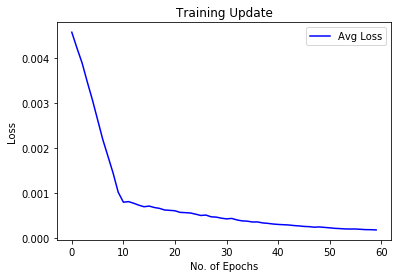

In [31]:
import pylab
iter = list(range(0,60))

#pylab.plot(iter, loss_true_per_epoch, '-y', label='True Loss')   
pylab.plot(iter, avg_loss_per_iter, '-b', label='Avg Loss')
pylab.legend(loc='upper right')
pylab.title("Training Update")  
pylab.ylabel('Loss')
pylab.xlabel('No. of Epochs')
pylab.show()

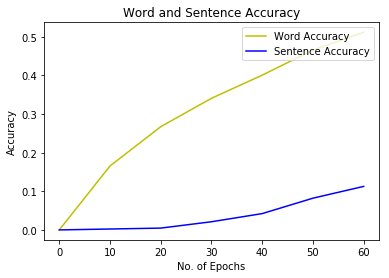

In [32]:
iter = list(range(0,70,10))
pylab.plot(iter, word_accur, '-y', label='Word Accuracy')   
pylab.plot(iter, sent_accur, '-b', label='Sentence Accuracy')
pylab.legend(loc='upper right')
pylab.title("Word and Sentence Accuracy")  
pylab.ylabel('Accuracy')
pylab.xlabel('No. of Epochs')
pylab.show()